<a href="https://colab.research.google.com/github/levhojoyan/Sirius2021/blob/main/NeuralWithWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch import distributions as distrs


from sklearn.datasets import load_boston
from tqdm.notebook import tqdm

from IPython.display import clear_output

%matplotlib inline

Создадим искусственные данные для задачи регрессии: синус + нормальный шум


In [2]:
# Красиво рисует двумерное распределение
def plot_2d_dots(dots, color='blue', label='None'):
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.scatter(dots[:, 0], dots[:, 1], s=1, c=color, label=label)

In [3]:
sample_size = 1024
batch_size = 1024
# x_s = torch.empty(sample_size).normal_(mean=0,std=1).unsqueeze(1)
x_s = torch.linspace(-3.14, 3.14, sample_size).unsqueeze(1)
noise_s = torch.empty(sample_size).normal_(mean=0,std=1)

print(x_s.shape)
f_s = torch.sin(x_s) # + noise_s 

sample_2d = torch.cat((x_s, f_s), dim=-1)

print(sample_2d.shape)

torch.Size([1024, 1])
torch.Size([1024, 2])


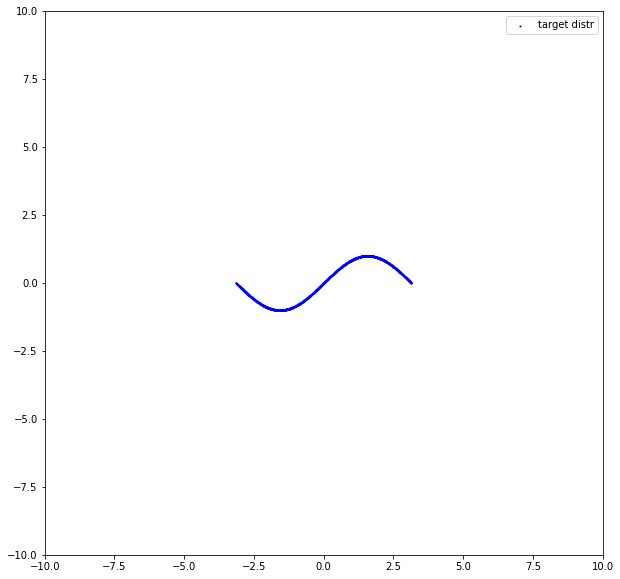

In [4]:
plt.figure(figsize=(10, 10))
plot_2d_dots(sample_2d, label='target distr')
plt.legend()
plt.show()

In [5]:
class RandomDataset(torch.utils.data.Dataset):
    """Our random dataset"""
    
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return {'sample': torch.tensor(self.x[idx], dtype=torch.float), 'target': self.y[idx]}

In [8]:
our_dataset = RandomDataset(x_s, f_s)
print(sample_2d.shape, x_s.shape)

torch.Size([1024, 2]) torch.Size([1024, 1])


In [148]:
print(our_dataset.__getitem__(1), sample_2d[1])

{'sample': tensor([-3.1339]), 'target': tensor([-0.0077])} tensor([-3.1339, -0.0077])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [51]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Linear(1, 512) # the simpliest
        # self.conv2 = nn.Linear(10, 20)
        # self.conv3 = nn.Linear(20, 10)
        self.conv4 = nn.Linear(512, 1)


    def forward(self, x):
      x = F.relu(self.conv1(x))
      # x = F.relu(self.conv2(x))
      # x = F.relu(self.conv3(x))
      x = self.conv4(x)

      return x

In [52]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=batch_size)

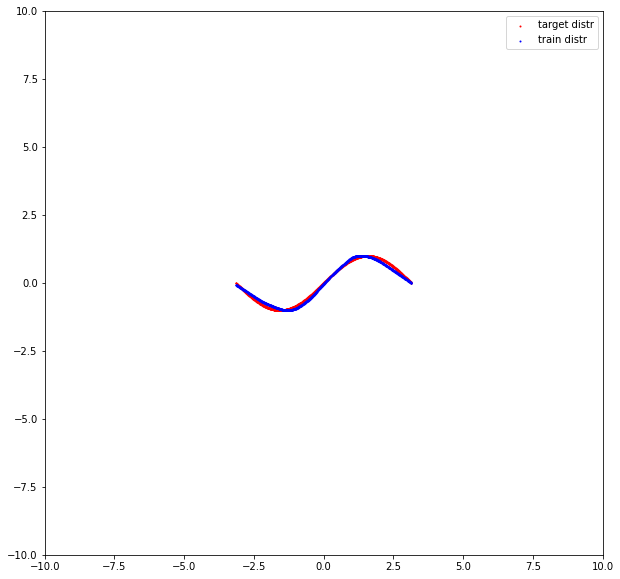

In [53]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mses = []

i = 0
for epoch in range(40):
  for batch in tqdm(dataloader): # берем батч из трейн лоадера
      x_train = batch['sample']
      y_train = batch['target']

      # print(x_train.shape, y_train.shape)
      y_pred = model(x_train) # делаем предсказания
      loss = torch.nn.MSELoss()(y_pred, y_train) # считаем лосс
      loss.backward() # считаем градиенты обратным проходом
      optimizer.step() # обновляем параметры сети
      optimizer.zero_grad() # обнуляем посчитанные градиенты параметров
      i += 1


      total_pred = model(x_s.unsqueeze(1))
      total_pred.detach_()

      mse = torch.nn.MSELoss()(f_s, total_pred)
      mses.append(mse)

      if i % 10 == 0:
        # plot pdfs
        clear_output(True)

        plt.figure(figsize=(10, 10))

        # print(x_s.shape, total_pred.shape)

        plot_2d_dots(sample_2d, color='r', label='target distr')
        plot_2d_dots(torch.cat((x_s.unsqueeze(1), total_pred), 1), color='b', label='train distr')
        plt.legend()
        plt.show() 


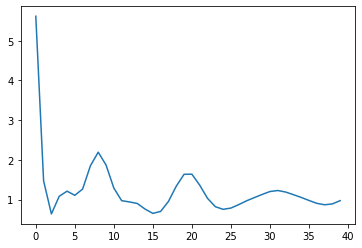

In [54]:
plt.plot(mses)

In [34]:
class ModelWithWeighted(nn.Module):
    def __init__(self):
        super(ModelWithWeighted, self).__init__()
        self.conv1 = nn.Linear(1, 512) # the simpliest
        self.conv2 = nn.Linear(512, 10) # the simpliest

    def forward(self, x):
      x = F.relu(self.conv1(x))

      return self.conv2(x)

In [73]:
model2 = ModelWithWeighted()
last_layer_weights = torch.rand(10, requires_grad=True)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)
optimizer2.add_param_group({'params':last_layer_weights})

i = 0
losses = []
mses = []
weighted_mses = []
for epoch in range(1):
  for batch in tqdm(dataloader): # берем батч из трейн лоадера

      if i % 2 == 0:
      plot pdfs
      with torch.no_grad():
        clear_output(True)
        plt.figure(figsize=(10, 10))
        
        norm_weights = F.softmax(last_layer_weights)
        y_pred_functions = model2(x_s)

        total_pred = torch.sum(y_pred_functions * norm_weights, dim=-1)
        
        print(x_s.shape, total_pred.shape)

        plot_2d_dots(sample_2d, color='r', label='target distr')
        plot_2d_dots(torch.cat((x_s, total_pred.unsqueeze(1)), dim=1), color='b', label='train distr')
        plt.legend()
        plt.show() 
        optimizer2.zero_grad()

        weighted_mse = torch.sum(norm_weights * ((y_pred_functions - f_s)**2)) # считаем взвешенное мсе

        y_pred_total = torch.sum(y_pred_functions * norm_weights, dim=-1) # делаем сквозь всю сетку
        total_mse = torch.nn.MSELoss()(total_pred, f_s)
        total_loss = total_mse + weighted_mse # считаем лосс

        losses.append(total_loss)
        weighted_mses.append(weighted_mse)
        mses.append(total_mse)







      x_train = batch['sample']
      y_train = batch['target']



      norm_weights = F.softmax(last_layer_weights)

      y_pred_functions = model2(x_train) # до последнего слоя
      print(y_pred_functions.shape, y_train.shape, norm_weights.shape)

      weighted_mse = torch.sum(norm_weights * ((y_pred_functions - y_train)**2)) # считаем взвешенное мсе
      print(weighted_mse.shape)


      y_pred = torch.sum(y_pred_functions * norm_weights, dim=-1) # делаем сквозь всю сетку

      print(y_pred.shape)

      mse = torch.nn.MSELoss()(y_pred, y_train) # считаем лосс


      total_loss = mse + weighted_mse # считаем лосс
      total_loss.backward() # считаем градиенты обратным проходом

      optimizer2.step() # обновляем параметры сети
      optimizer2.zero_grad() # обнуляем посчитанные градиенты параметров
      i += 1

torch.Size([1024, 10]) torch.Size([1024, 1]) torch.Size([10])
torch.Size([])
torch.Size([1024])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1024, 1])) that is different to the input size (torch.Size([1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


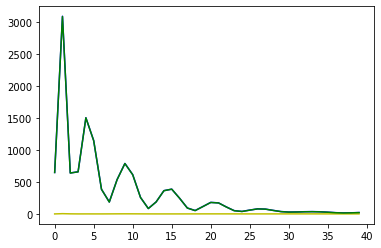

In [48]:
plt.plot(losses, color='b')
plt.plot(mses, color='y')
plt.plot(weighted_mses, color='g')

In [49]:
F.softmax(last_layer_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([0.0758, 0.1167, 0.0966, 0.0822, 0.1031, 0.0802, 0.1434, 0.0683, 0.0864,
        0.1475], grad_fn=<SoftmaxBackward>)

In [50]:
print(weighted_mses[0], mses[0])
print(weighted_mses[-1], mses[-1])

tensor(647.8301) tensor(0.5005)
tensor(20.8847) tensor(1.0070)


torch.Size([2]) torch.Size([2, 1])
tensor([[3, 3],
        [3, 3]])


torch.Size([1024, 10]) torch.Size([1024, 1])


In [64]:
f_x = torch.ones((20, 2))
y_s =  torch.ones((20, 1)) * 2
w = torch.ones((2)) * 3

print(a, b, w)

ans = w*(f_x - y_s)**2

torch.sum(ans)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]) tensor([[2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]]) tensor([3., 3.])


In [76]:
torch.sum(torch.tensor([1])).shape

torch.Size([])

tensor(120.)